<a href="https://colab.research.google.com/github/spshreya/Data_science_projects/blob/main/demand_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [2]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.0 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import itertools
import holidays
import requests
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_absolute_percentage_error

import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

## Reading the data

In [4]:
train_df = pd.read_csv('train.csv')

In [5]:
test_df = pd.read_csv('test.csv')

## Exploratory Data Analysis

In [6]:
train_df.head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [7]:
test_df.head()

,id,date,country,store,product
0,230130,2017-01-01,Canada,Discount Stickers,Holographic Goose
1,230131,2017-01-01,Canada,Discount Stickers,Kaggle
2,230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers
3,230133,2017-01-01,Canada,Discount Stickers,Kerneler
4,230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB


In [9]:
train_df['date'] = pd.to_datetime(train_df['date'])

In [10]:
#setting id as index
train_df.set_index('id', inplace=True)

In [11]:
train_df.date.min()

Timestamp('2010-01-01 00:00:00')

In [12]:
train_df.date.max()

Timestamp('2016-12-31 00:00:00')

In [13]:
train_df.country.value_counts()

,count
country,
Canada,38355
Finland,38355
Italy,38355
Kenya,38355
Norway,38355
Singapore,38355


In [14]:
train_df.store.value_counts()

,count
store,
Discount Stickers,76710
Stickers for Less,76710
Premium Sticker Mart,76710


In [15]:
train_df['product'].value_counts()

,count
product,
Holographic Goose,46026
Kaggle,46026
Kaggle Tiers,46026
Kerneler,46026
Kerneler Dark Mode,46026


In [16]:
df_grouped = train_df.groupby(['country', 'store', 'product'])['num_sold'].sum().reset_index()
df_grouped

,country,store,product,num_sold
0,Canada,Discount Stickers,Holographic Goose,0.0
1,Canada,Discount Stickers,Kaggle,1829924.0
2,Canada,Discount Stickers,Kaggle Tiers,1515225.0
3,Canada,Discount Stickers,Kerneler,827127.0
4,Canada,Discount Stickers,Kerneler Dark Mode,965988.0
...,...,...,...,...
85,Singapore,Stickers for Less,Holographic Goose,586737.0
86,Singapore,Stickers for Less,Kaggle,4201315.0
87,Singapore,Stickers for Less,Kaggle Tiers,3469701.0
88,Singapore,Stickers for Less,Kerneler,1895672.0


In [17]:
df_grouped.sort_values(by='num_sold', ascending=False)

,country,store,product,num_sold
66,Norway,Premium Sticker Mart,Kaggle,8177022.0
71,Norway,Stickers for Less,Kaggle,6917719.0
67,Norway,Premium Sticker Mart,Kaggle Tiers,6757456.0
72,Norway,Stickers for Less,Kaggle Tiers,5717409.0
81,Singapore,Premium Sticker Mart,Kaggle,4955153.0
...,...,...,...,...
48,Kenya,Discount Stickers,Kerneler,18902.0
50,Kenya,Premium Sticker Mart,Holographic Goose,11355.0
55,Kenya,Stickers for Less,Holographic Goose,6559.0
0,Canada,Discount Stickers,Holographic Goose,0.0


In [18]:
df_grouped.num_sold.describe()

,num_sold
count,9.000000e+01
mean,1.850038e+06
std,1.727954e+06
min,0.000000e+00
25%,4.852760e+05
50%,1.529175e+06
75%,2.779639e+06
max,8.177022e+06


In [19]:
train_df.groupby(['country'])['num_sold'].sum().reset_index().sort_values(by='num_sold', ascending=False)

,country,num_sold
4,Norway,54562305.0
5,Singapore,33102374.0
1,Finland,28698872.0
0,Canada,28653095.0
2,Italy,20797669.0
3,Kenya,689141.0


In [20]:
train_df.groupby(['country', 'store'])['num_sold'].sum().reset_index().sort_values(by='num_sold', ascending=False)

,country,store,num_sold
13,Norway,Premium Sticker Mart,24084870.0
14,Norway,Stickers for Less,20396815.0
16,Singapore,Premium Sticker Mart,14611960.0
1,Canada,Premium Sticker Mart,12832976.0
4,Finland,Premium Sticker Mart,12675641.0
17,Singapore,Stickers for Less,12370921.0
5,Finland,Stickers for Less,10723058.0
2,Canada,Stickers for Less,10681855.0
12,Norway,Discount Stickers,10080620.0
7,Italy,Premium Sticker Mart,9188782.0


In [21]:
train_df.groupby(['store'])['num_sold'].sum().reset_index().sort_values(by='num_sold', ascending=False)

,store,num_sold
1,Premium Sticker Mart,73703822.0
2,Stickers for Less,62200397.0
0,Discount Stickers,30599237.0


In [22]:
train_df.groupby(['product'])['num_sold'].sum().reset_index().sort_values(by='num_sold', ascending=False)

,product,num_sold
1,Kaggle,56721733.0
2,Kaggle Tiers,46870306.0
4,Kerneler Dark Mode,29964209.0
3,Kerneler,25596840.0
0,Holographic Goose,7350368.0


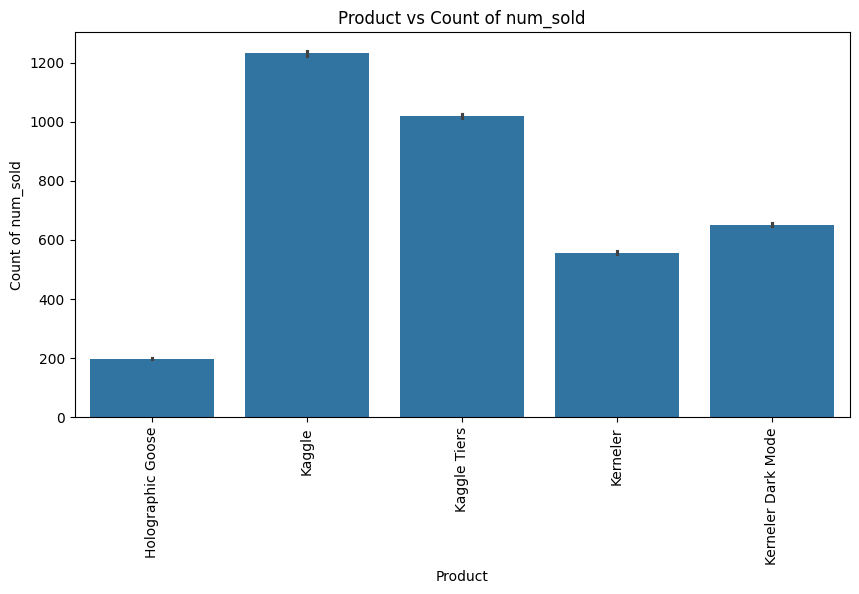

In [23]:
#plot for product and count of num_sold
plt.figure(figsize=(10, 5))
sns.barplot(data=train_df, x='product', y='num_sold')
plt.xlabel('Product')
plt.ylabel('Count of num_sold')
plt.title('Product vs Count of num_sold')
plt.xticks(rotation=90)
plt.show()

In [24]:
train_df.num_sold.describe()

,num_sold
count,221259.000000
mean,752.527382
std,690.165445
min,5.000000
25%,219.000000
50%,605.000000
75%,1114.000000
max,5939.000000


### Exploring Nans in num_sold

In [25]:
total_nans = train_df['num_sold'].isna().sum()
percent_nans = (total_nans / len(train_df)) * 100
print(f"Total NaNs in 'num_sold': {total_nans}")
print(f"Percentage of NaNs in 'num_sold': {percent_nans:.2f}%")

Total NaNs in 'num_sold': 8871
Percentage of NaNs in 'num_sold': 3.85%


In [26]:
country_nan_analysis = train_df[train_df['num_sold'].isna()].groupby('country').size().reset_index(name='nan_count')
print(country_nan_analysis)

  country  nan_count
0  Canada       4246
1   Kenya       4625


In [27]:
store_nan_analysis = train_df[train_df['num_sold'].isna()].groupby('store').size().reset_index(name='nan_count')
print(store_nan_analysis)

                  store  nan_count
0     Discount Stickers       5179
1  Premium Sticker Mart       1026
2     Stickers for Less       2666


In [28]:
product_nan_analysis = train_df[train_df['num_sold'].isna()].groupby('product').size().reset_index(name='nan_count')
print(product_nan_analysis)

              product  nan_count
0   Holographic Goose       8806
1            Kerneler         64
2  Kerneler Dark Mode          1


In [29]:
date_nan_analysis = train_df[train_df['num_sold'].isna()].groupby('date').size().reset_index(name='nan_count').sort_values(by='nan_count', ascending=False)
date_nan_analysis

,date,nan_count
110,2010-04-21,7
90,2010-04-01,7
130,2010-05-11,7
151,2010-06-01,7
204,2010-07-24,6
...,...,...
1527,2014-03-08,2
1528,2014-03-09,2
1529,2014-03-10,2
1530,2014-03-11,2


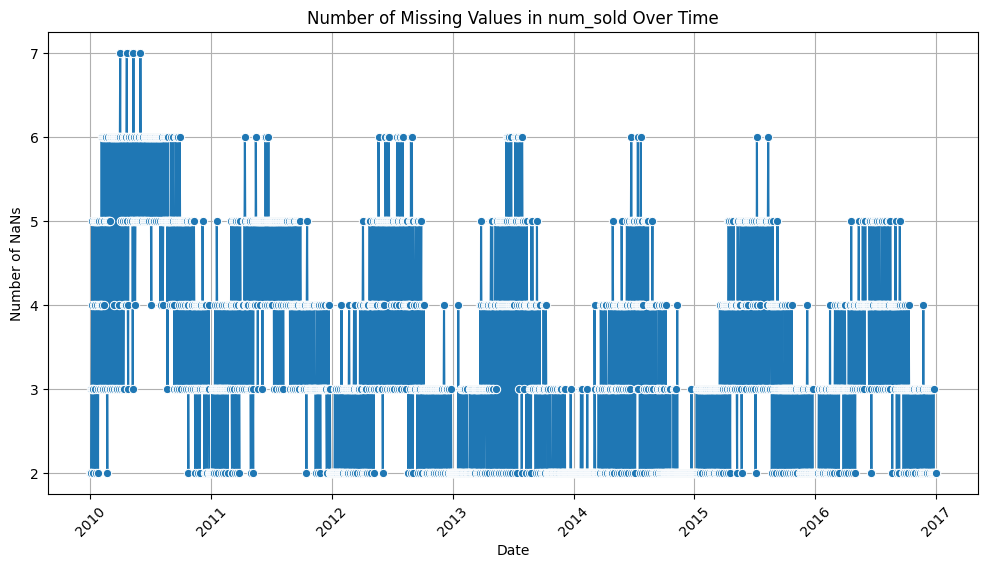

In [30]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=date_nan_analysis, x='date', y='nan_count', marker='o')
plt.title('Number of Missing Values in num_sold Over Time')
plt.xlabel('Date')
plt.ylabel('Number of NaNs')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [31]:
train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.day
train_df['day_of_week'] = train_df['date'].dt.dayofweek  # Monday=0, Sunday=6
train_df['week_of_year'] = train_df['date'].dt.isocalendar().week

In [32]:
train_df.head()

,date,country,store,product,num_sold,year,month,day,day_of_week,week_of_year
id,,,,,,,,,,
0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN,2010,1,1,4,53
1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,2010,1,1,4,53
2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,2010,1,1,4,53
3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,2010,1,1,4,53
4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,2010,1,1,4,53


In [33]:
date_nan_count = train_df[train_df['num_sold'].isna()].groupby('date').size().reset_index(name='nan_count')
print(date_nan_count.head())

        date  nan_count
0 2010-01-01          2
1 2010-01-02          2
2 2010-01-03          2
3 2010-01-04          3
4 2010-01-05          3


In [34]:
year_nan_count = train_df[train_df['num_sold'].isna()].groupby('year').size().reset_index(name='nan_count')
print(year_nan_count.sort_values(by='nan_count', ascending=False))

   year  nan_count
0  2010       1709
1  2011       1405
2  2012       1221
5  2015       1207
6  2016       1173
3  2013       1129
4  2014       1027


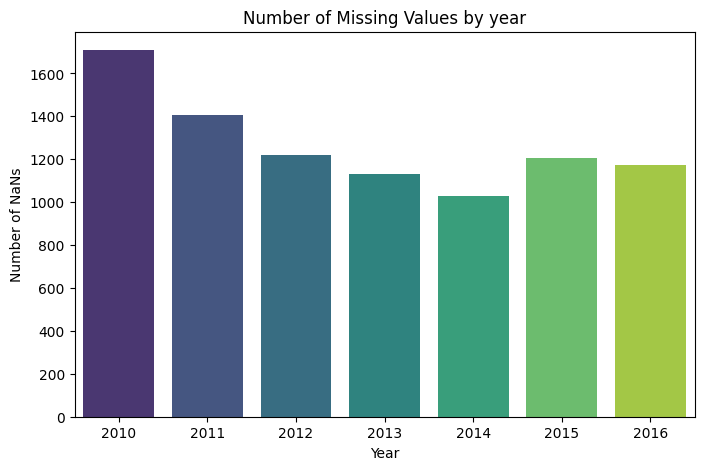

In [35]:
plt.figure(figsize=(8, 5))
sns.barplot(data=year_nan_count, x='year', y='nan_count', palette='viridis')
plt.title('Number of Missing Values by year')
plt.xlabel('Year')
plt.ylabel('Number of NaNs')
plt.show()

In [36]:
month_nan_count = train_df[train_df['num_sold'].isna()].groupby('month').size().reset_index(name='nan_count')
print(month_nan_count.sort_values(by='nan_count', ascending=False))

    month  nan_count
6       7        985
5       6        942
7       8        920
4       5        896
3       4        771
8       9        751
2       3        721
9      10        654
10     11        576
1       2        564
0       1        555
11     12        536


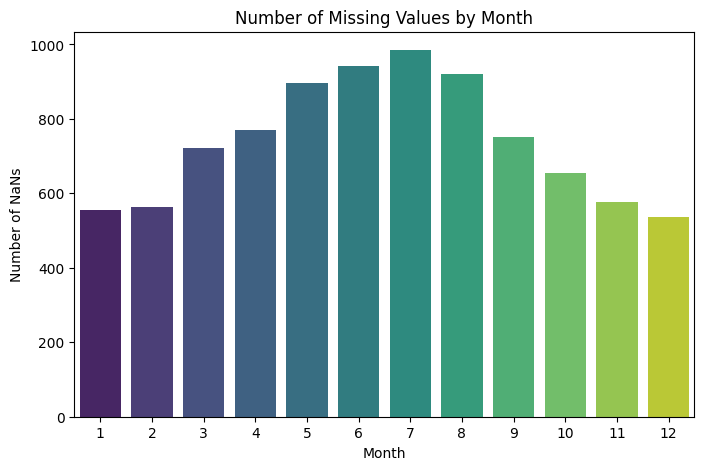

In [37]:
plt.figure(figsize=(8, 5))
sns.barplot(data=month_nan_count, x='month', y='nan_count', palette='viridis')
plt.title('Number of Missing Values by Month')
plt.xlabel('Month')
plt.ylabel('Number of NaNs')
plt.show()

In [38]:
dow_nan_count = train_df[train_df['num_sold'].isna()].groupby('day_of_week').size().reset_index(name='nan_count')
print(dow_nan_count.sort_values(by='nan_count', ascending=False))

   day_of_week  nan_count
0            0       1418
2            2       1418
3            3       1416
1            1       1406
4            4       1234
5            5       1087
6            6        892


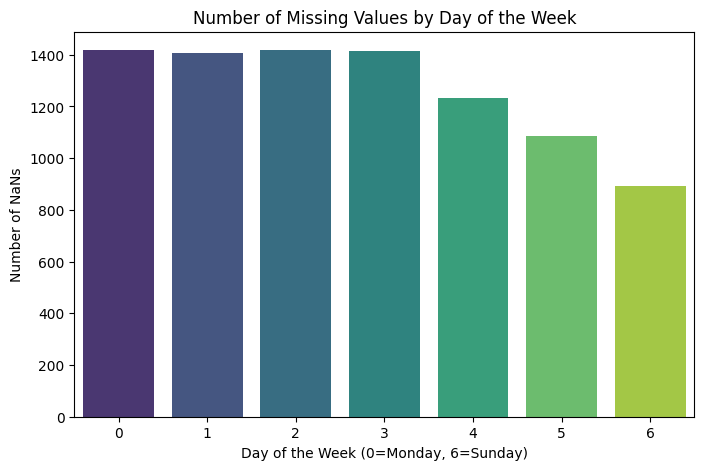

In [39]:
plt.figure(figsize=(8, 5))
sns.barplot(data=dow_nan_count, x='day_of_week', y='nan_count', palette='viridis')
plt.title('Number of Missing Values by Day of the Week')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Number of NaNs')
plt.show()

In [40]:
week_nan_count = train_df[train_df['num_sold'].isna()].groupby('week_of_year').size().reset_index(name='nan_count')
print(week_nan_count.sort_values(by='nan_count', ascending=False))

    week_of_year  nan_count
28            29        229
24            25        226
25            26        225
27            28        223
29            30        221
30            31        219
23            24        219
31            32        218
21            22        217
26            27        216
20            21        215
32            33        211
22            23        210
19            20        202
34            35        197
18            19        197
33            34        195
16            17        190
17            18        189
15            16        181
36            37        179
12            13        177
14            15        176
35            36        176
37            38        172
38            39        172
13            14        167
11            12        161
39            40        159
10            11        158
9             10        158
40            41        152
8              9        149
7              8        144
41            42    

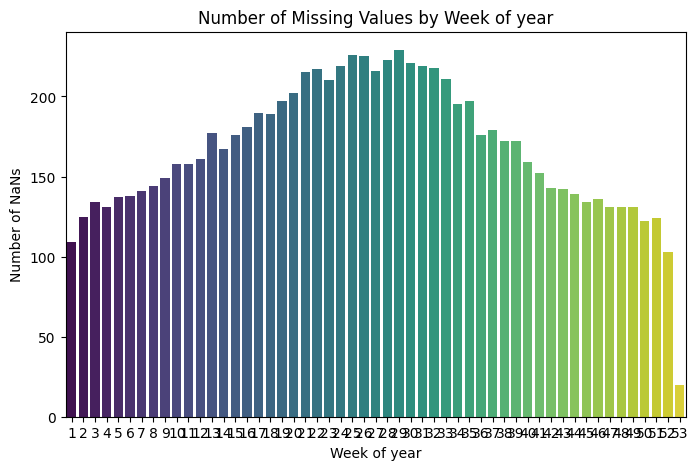

In [41]:
plt.figure(figsize=(8, 5))
sns.barplot(data=week_nan_count, x='week_of_year', y='nan_count', palette='viridis')
plt.title('Number of Missing Values by Week of year')
plt.xlabel('Week of year')
plt.ylabel('Number of NaNs')
plt.show()

### Adding holidays

In [42]:
train_df["holidays"] = 0
alpha2 = dict(zip(np.sort(train_df.country.unique()), ['CA', 'FI', 'IT', 'KE', 'NO', 'SG']))
h = {c: holidays.country_holidays(a, years=range(2010, 2020)) for c, a in alpha2.items()}
for c in alpha2:
    train_df.loc[train_df.country==c, 'holidays'] = train_df.date.isin(h[c]).astype(int)

In [43]:
#groupby country and value counts of holidays
train_df.groupby('country')['holidays'].value_counts()

country    holidays
Canada     0           37755
           1             600
Finland    0           36780
           1            1575
Italy      0           37095
           1            1260
Kenya      0           37275
           1            1080
Norway     0           37110
           1            1245
Singapore  0           36990
           1            1365
Name: count, dtype: int64

In [44]:
holiday_nan_analysis = train_df[train_df['num_sold'].isna()].groupby('holidays').size().reset_index(name='nan_count')
print(holiday_nan_analysis)

   holidays  nan_count
0         0       8694
1         1        177


to-do: % count against number of holidays

### Exploring the descomposition of different categories across dates / years

The function visualizes how each category (c) contributes to the total sales (num_sold) over time. This helps in identifying temporal patterns or seasonality in the contributions of different categories.

In [45]:
def decompose(train, c, ax):
    df = train.groupby(['date',c])[['num_sold']].sum().reset_index().join(
                            train_df.groupby('date')[['num_sold']].sum(), on='date',rsuffix='_global')
    df['fractions'] = df['num_sold']/df['num_sold_global']
    for m in np.sort(df[c].unique()):
        mask = df[c]==m
        ax.plot(df[mask]['date'],df[mask]['fractions'],label=m)
    ax.legend(bbox_to_anchor=(1, 1))

function by https://www.kaggle.com/competitions/playground-series-s5e1/discussion/554349

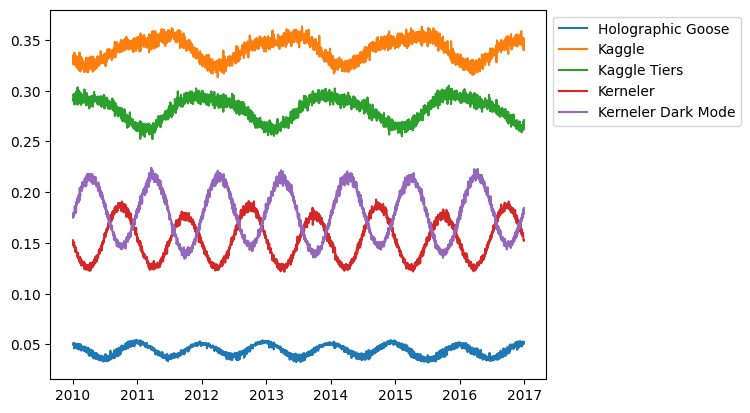

In [46]:
_, ax = plt.subplots()
decompose(train_df, 'product', ax)
plt.show()

 the y-axis represents the fraction of total sales contributed by each product on any given date.

 The y-axis values indicate the proportion of sales for each product compared to the global sales on that day.

For example:

If the fraction is 0.3, it means that the product contributed 30% of the total sales for that date.
The oscillations and patterns in the plot reveal how the contribution of each product changes over time.

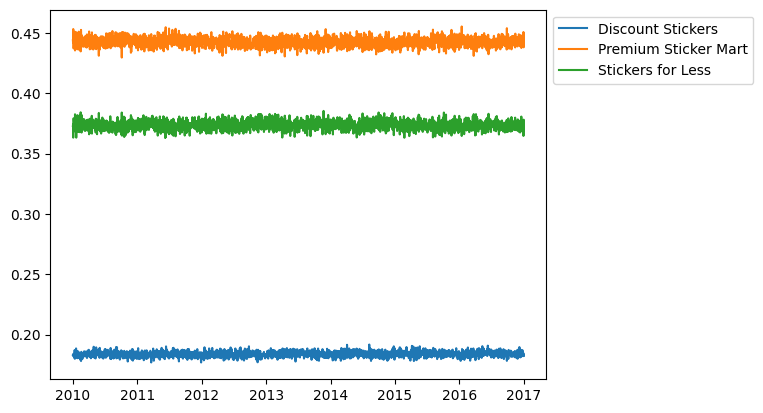

In [47]:
_, ax = plt.subplots()
decompose(train_df, 'store', ax)
plt.show()

This code integrates GDP per capita data into the analysis of sales trends and visualizes the relationship between GDP and the fraction of total sales for each country.

source: https://www.kaggle.com/competitions/playground-series-s5e1/discussion/554349


### What This Code Achieves

* Fetches GDP per capita data for the countries in the dataset over the
years present in the sales data.
* Normalizes GDP to represent relative contributions by country in each year.
* Plots sales fractions and GDP trends, providing insights into the relationship between GDP and sales:
  1. Are higher-GDP countries contributing more to total sales?
  2. Are there any patterns between GDP trends and sales fractions?

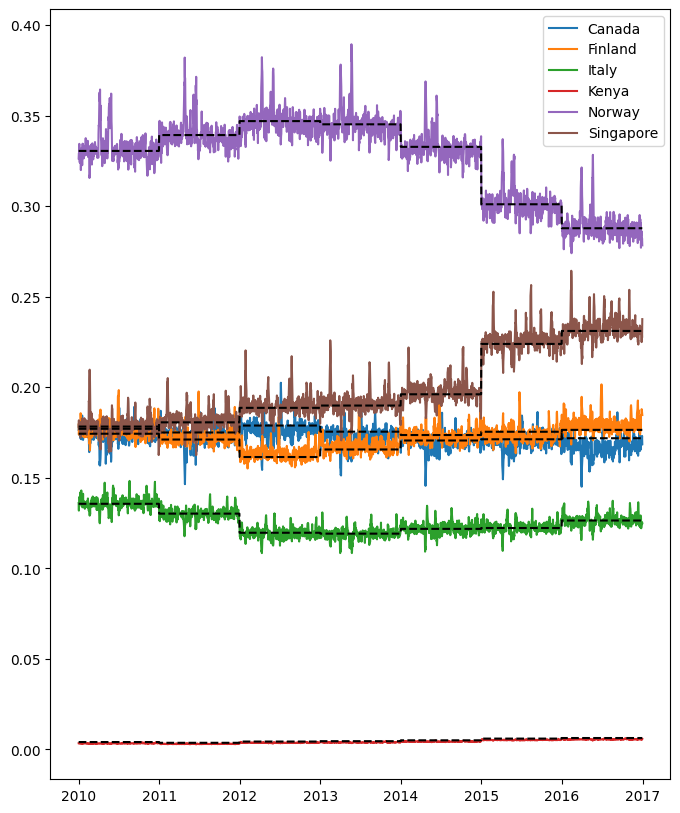

In [53]:
def get_gdp_per_capita(alpha3, year):
    url='https://api.worldbank.org/v2/country/{0}/indicator/NY.GDP.PCAP.CD?date={1}&format=json'
    response = requests.get(url.format(alpha3,year)).json()
    return response[1][0]['value']

df = train_df.copy()
alpha3s = ['CAN', 'FIN', 'ITA', 'KEN', 'NOR', 'SGP']
df['alpha3'] = df['country'].map(dict(zip(
    np.sort(df['country'].unique()), alpha3s)))
years = np.sort(df['date'].dt.year.unique())
df['year'] = df['date'].dt.year
gdp = np.array([
    [get_gdp_per_capita(alpha3, year) for year in years]
    for alpha3 in alpha3s
])
gdp = pd.DataFrame(gdp/gdp.sum(axis=0), index=alpha3s, columns=years)
df['GDP'] = df.apply(lambda s: gdp.loc[s['alpha3'], s['year']], axis=1)

_, ax = plt.subplots(figsize=(8,10))

decompose(train_df, 'country', ax)

for country in df['country'].unique():
    mask = df['country']==country
    ax.plot(df[mask]['date'],df[mask]['GDP'],'k--')
plt.show()

This plot compares the fraction of total sales contributed by each country (`num_sold` as a percentage of the global total) with their normalized GDP trends (dashed lines). Here’s how to interpret the key components:

1. **Solid Lines (Sales Fractions)**:
   - Each country's contribution to total sales (`fractions` column) is plotted over time.
   - For example, Norway (purple line) appears to contribute the highest fraction of sales, whereas Singapore has the lowest.

2. **Dashed Lines (Normalized GDP)**:
   - The dashed lines represent the normalized GDP per capita for each country over the years.
   - These are aligned with the sales data, allowing you to visually compare GDP trends with sales fractions.


This code visualizes the relationship between a country's annual GDP per capita and the total number of items sold annually (num_sold)

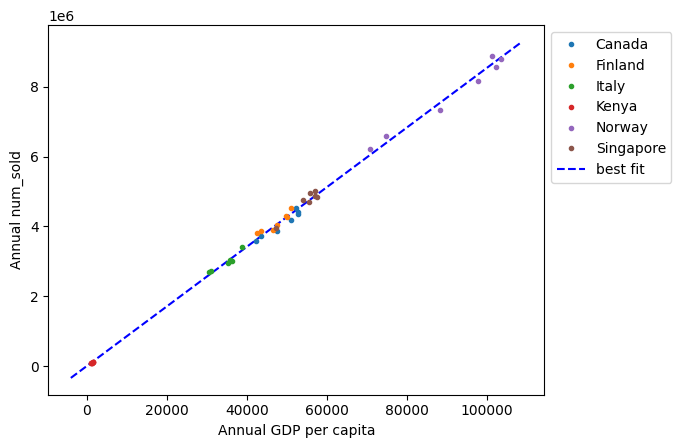

In [49]:
X = train_df.copy()
X['year'] = X['date'].dt.year
x = []
y = []
alpha3s = ['CAN', 'FIN', 'ITA', 'KEN', 'NOR', 'SGP']
alpha3_dict = dict(zip(np.sort(X['country'].unique()), alpha3s))
years = np.sort(X['year'].unique())
for c in X.country.unique():
    x += [get_gdp_per_capita(alpha3_dict[c], yr) for yr in years]
    y += X[X.country==c].groupby('year')['num_sold'].sum().to_list()
    plt.plot(x[-len(years):], y[-len(years):], '.', label=c)
xlim = list(plt.gca().get_xlim())
plt.plot(xlim, np.poly1d(np.polyfit(x, y, 1))(xlim),
         'b--', zorder=-1, label='best fit')
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('Annual GDP per capita')
plt.ylabel('Annual num_sold')
plt.show()

**Purpose:**
This code explores how GDP per capita correlates with the total number of items sold annually. The scatter points show individual countries' data, while the blue dashed line indicates the overall linear trend across all countries.

**Insights to Look For:**

1. **Slope of the Best-Fit Line:**
A positive slope suggests a direct correlation between GDP and sales, while a negative slope would imply an inverse relationship.
2. **Scatter Distribution:**Are countries tightly clustered, or is there significant variation in GDP-to-sales relationships?
3. **Outliers:** Identify any countries with unusual sales behavior compared to their GDP per capita.


In [54]:
df.head()

,date,country,store,product,num_sold,year,month,day,day_of_week,week_of_year,holidays,alpha3,GDP
id,,,,,,,,,,,,,
0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN,2010,1,1,4,53,1,CAN,0.178301
1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,2010,1,1,4,53,1,CAN,0.178301
2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,2010,1,1,4,53,1,CAN,0.178301
3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,2010,1,1,4,53,1,CAN,0.178301
4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,2010,1,1,4,53,1,CAN,0.178301


### MODEL WITHOUT FILLING IN NANS IN NUM_SOLD

In [55]:
df_complete = df.dropna(subset=['num_sold'])

In [57]:
X = df_complete[['country', 'store', 'product', 'GDP', 'year', 'month','week_of_year']]  # Feature columns
y = df_complete['num_sold']  # Target column

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Specify categorical features (indexes or names of categorical columns in X)
categorical_features = ['country', 'store', 'product']  # Replace with actual categorical column names

# Define the CatBoost regressor
catboost_model = CatBoostRegressor(
    iterations=500,
    depth=6,
    learning_rate=0.1,
    loss_function='RMSE',  # CatBoost supports RMSE; we'll calculate MAPE externally
    cat_features=categorical_features,
    verbose=100
)

# Use a log transformation for the target variable
log_transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1)

# Wrap CatBoost with TransformedTargetRegressor
model = TransformedTargetRegressor(
    regressor=catboost_model,
    transformer=log_transformer
)

# Fit the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

0:	learn: 1.3777689	total: 263ms	remaining: 2m 11s
100:	learn: 0.1069947	total: 11.4s	remaining: 44.9s
200:	learn: 0.1011138	total: 20.1s	remaining: 29.8s
300:	learn: 0.0985104	total: 31.9s	remaining: 21.1s
400:	learn: 0.0967647	total: 43.7s	remaining: 10.8s
499:	learn: 0.0954845	total: 57.5s	remaining: 0us


In [58]:
mape = mean_absolute_percentage_error(y_test, np.ceil(y_pred))
print(f'MAPE: {mape:.2f}%')

MAPE: 0.08%


In [59]:
feature_importances = model.regressor_.get_feature_importance()

# Create a DataFrame to display feature names and their corresponding importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importance
print(feature_importance_df)

        Feature  Importance
3           GDP   77.094071
2       product   15.044991
1         store    6.721182
4          year    0.428388
6  week_of_year    0.378959
5         month    0.318102
0       country    0.014308


In [60]:
#changing date to datetime
test_df['date'] = pd.to_datetime(test_df['date'])

In [62]:
#setting id as index
test_df.set_index('id', inplace=True)

In [63]:
test_df['year'] = test_df['date'].dt.year
test_df['month'] = test_df['date'].dt.month
test_df['week_of_year'] = test_df['date'].dt.isocalendar().week

In [64]:
alpha3s = ['CAN', 'FIN', 'ITA', 'KEN', 'NOR', 'SGP']
test_df['alpha3'] = test_df['country'].map(dict(zip(
    np.sort(test_df['country'].unique()), alpha3s)))
years = np.sort(test_df['date'].dt.year.unique())
test_df['year'] = test_df['date'].dt.year
gdp = np.array([
    [get_gdp_per_capita(alpha3, year) for year in years]
    for alpha3 in alpha3s
])
gdp = pd.DataFrame(gdp/gdp.sum(axis=0), index=alpha3s, columns=years)
test_df['GDP'] = test_df.apply(lambda s: gdp.loc[s['alpha3'], s['year']], axis=1)

In [65]:
test_df["holidays"] = 0
alpha2 = dict(zip(np.sort(test_df.country.unique()), ['CA', 'FI', 'IT', 'KE', 'NO', 'SG']))
h = {c: holidays.country_holidays(a, years=range(2010, 2020)) for c, a in alpha2.items()}
for c in alpha2:
    test_df.loc[test_df.country==c, 'holidays'] = test_df.date.isin(h[c]).astype(int)

In [66]:
predictions = model.predict(test_df[['country', 'store', 'product', 'GDP', 'year', 'month','week_of_year']])

### FILLING NAS WITH GDP CORRELATION TO NUM_SOLD

In [50]:
# Compute avg_ratio for each country and year
df['sales_fraction'] = df['num_sold'] / df.groupby('date')['num_sold'].transform('sum')
avg_ratio = df.groupby(['country', 'year'])['num_sold'].sum() / df.groupby(['country', 'year'])['GDP'].sum()

# Fill missing values
missing_data = df[df['num_sold'].isna()]
missing_data['num_sold'] = missing_data.apply(
    lambda row: row['GDP'] * avg_ratio.loc[(row['country'], row['year'])], axis=1
)

In [51]:
df.loc[df['num_sold'].isna(), 'num_sold'] = missing_data['num_sold']

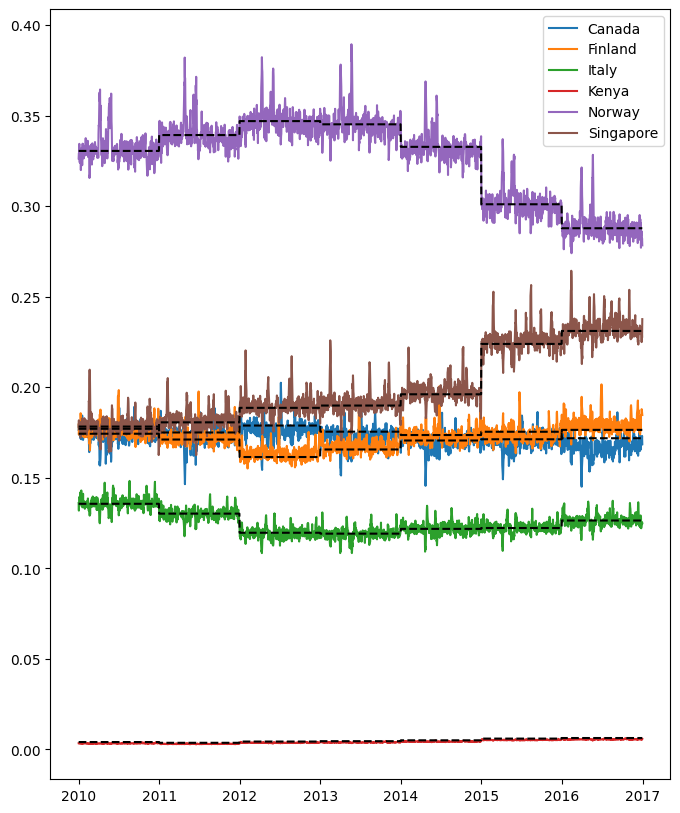

In [52]:
_, ax = plt.subplots(figsize=(8,10))

decompose(train_df, 'country', ax)

for country in df['country'].unique():
    mask = df['country']==country
    ax.plot(df[mask]['date'],df[mask]['GDP'],'k--')
plt.show()

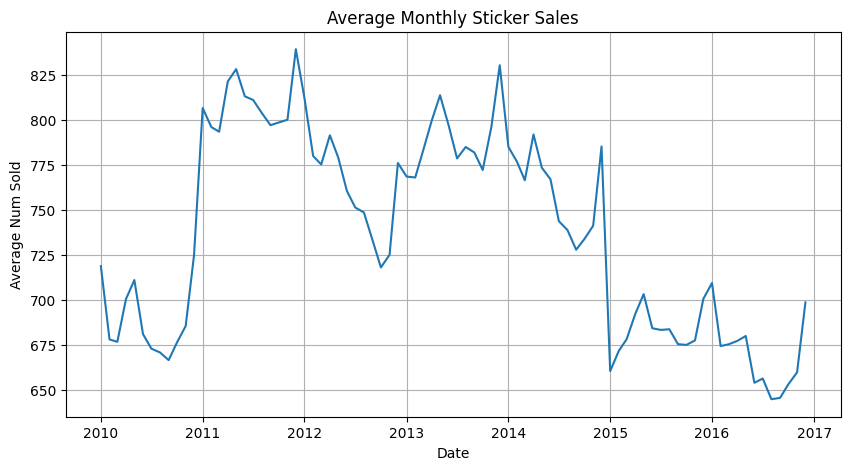

In [ ]:
#line graph of num sold average monthly over every month of date

monthly_avg = df.groupby(df['date'].dt.to_period('M'))['num_sold'].mean().reset_index()
monthly_avg['date'] = monthly_avg['date'].dt.to_timestamp()

# Plot the line graph
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_avg, x='date', y='num_sold')
plt.xlabel('Date')
plt.ylabel('Average Num Sold')
plt.title('Average Monthly Sticker Sales')
plt.grid(True)
plt.show()


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

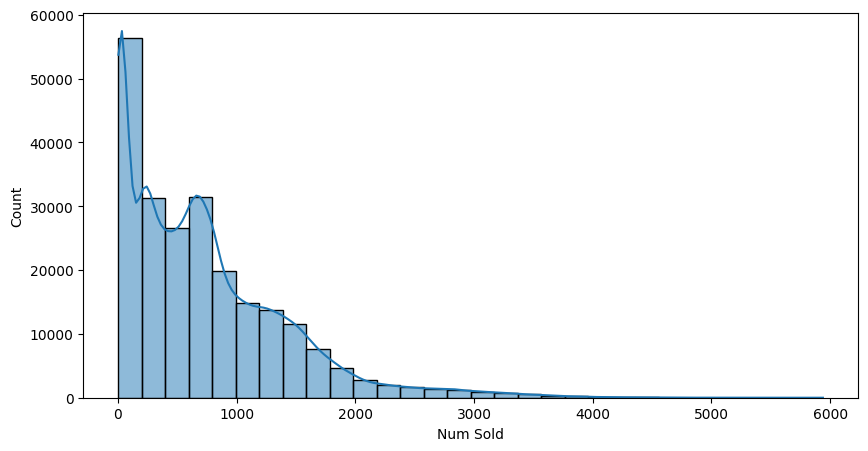

In [ ]:
#plotting the distribution of num_sold
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='num_sold', bins=30, kde=True)
plt.xlabel('Num Sold')
plt

### Regression based model

In [ ]:
X = df[['country', 'store', 'product', 'GDP', 'year', 'month','week_of_year']]  # Feature columns
y = df['num_sold']  # Target column

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Specify categorical features (indexes or names of categorical columns in X)
categorical_features = ['country', 'store', 'product']  # Replace with actual categorical column names

# Define the CatBoost regressor
catboost_model = CatBoostRegressor(
    iterations=500,
    depth=6,
    learning_rate=0.1,
    loss_function='RMSE',  # CatBoost supports RMSE; we'll calculate MAPE externally
    cat_features=categorical_features,
    verbose=100
)

# Use a log transformation for the target variable
log_transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1)

# Wrap CatBoost with TransformedTargetRegressor
model = TransformedTargetRegressor(
    regressor=catboost_model,
    transformer=log_transformer
)

# Fit the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

0:	learn: 1.4111287	total: 135ms	remaining: 1m 7s
100:	learn: 0.1430411	total: 10.4s	remaining: 41.1s
200:	learn: 0.1333016	total: 20.4s	remaining: 30.4s
300:	learn: 0.1295421	total: 29.1s	remaining: 19.2s
400:	learn: 0.1271958	total: 40.3s	remaining: 9.94s
499:	learn: 0.1255283	total: 50.9s	remaining: 0us


In [ ]:
# Evaluate the model using MAPE
mape = mean_absolute_percentage_error(y_test, np.ceil(y_pred))
print(f'MAPE: {mape:.2f}%')

MAPE: 0.09%


In [ ]:
X1 = df[['country', 'store', 'product', 'GDP', 'week_of_year']]  # Feature columns
y1= df['num_sold']  # Target column

# Split the data
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

# Specify categorical features (indexes or names of categorical columns in X)
categorical_features = ['country', 'store', 'product']  # Replace with actual categorical column names

# Define the CatBoost regressor
catboost_model_1 = CatBoostRegressor(
    iterations=500,
    depth=6,
    learning_rate=0.1,
    loss_function='RMSE',  # CatBoost supports RMSE; we'll calculate MAPE externally
    cat_features=categorical_features,
    verbose=100
)

# Use a log transformation for the target variable
log_transformer_1 = FunctionTransformer(np.log1p, inverse_func=np.expm1)

# Wrap CatBoost with TransformedTargetRegressor
model_1 = TransformedTargetRegressor(
    regressor=catboost_model_1,
    transformer=log_transformer_1
)

# Fit the model
model_1.fit(X1_train, y1_train)

# Predict on the test set
y1_pred = model_1.predict(X1_test)

0:	learn: 1.4116888	total: 132ms	remaining: 1m 6s
100:	learn: 0.1505519	total: 8.36s	remaining: 33s
200:	learn: 0.1369392	total: 21.2s	remaining: 31.5s
300:	learn: 0.1326959	total: 33s	remaining: 21.8s
400:	learn: 0.1304745	total: 43.3s	remaining: 10.7s
499:	learn: 0.1286302	total: 51.7s	remaining: 0us


In [ ]:
# Evaluate the model using MAPE
mape1 = mean_absolute_percentage_error(y1_test, y1_pred)
print(f'MAPE: {mape1:.2f}%')

MAPE: 0.09%


In [ ]:
test_df.head()

,date,country,store,product,year,month,week_of_year,alpha3,GDP,holidays
id,,,,,,,,,,
230130,2017-01-01,Canada,Discount Stickers,Holographic Goose,2017,1,52,CAN,0.171772,1
230131,2017-01-01,Canada,Discount Stickers,Kaggle,2017,1,52,CAN,0.171772,1
230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers,2017,1,52,CAN,0.171772,1
230133,2017-01-01,Canada,Discount Stickers,Kerneler,2017,1,52,CAN,0.171772,1
230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode,2017,1,52,CAN,0.171772,1


In [ ]:
predictions = model.predict(test_df[['country', 'store', 'product', 'GDP', 'year', 'month','week_of_year']])

In [ ]:
feature_importances = model.regressor_.get_feature_importance()

# Create a DataFrame to display feature names and their corresponding importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importance
print(feature_importance_df)

        Feature  Importance
3           GDP   70.316827
2       product   16.108695
1         store    9.208014
0       country    2.931060
6  week_of_year    0.582102
4          year    0.556322
5         month    0.296980


In [67]:
predictions_with_ids = pd.DataFrame({
    'id': test_df.index,
    'num_sold': np.round(predictions)
})

In [69]:
predictions_with_ids.to_csv('submission_1.csv', index=False)